# Time Series Analysis

This notebook estimates autocorrelations and different time series models (AR, MA and VAR).

## Load Packages and Extra Functions

The key functions in this notebook are from the (local) `FinEcmt_TimeSeries` module, but we also use [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package for estimating autocorrelations. 

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS, FinEcmt_TimeSeries
using FinEcmt_MLEGMM: MLE

In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
include(joinpath(pwd(),"src","FinEcmt_TimeSeries.jl"))
using .FiniteDiff: finite_difference_hessian as hessian, finite_difference_jacobian as jacobian
using .FinEcmt_OLS, .FinEcmt_TimeSeries
using .FinEcmt_MLEGMM: MLE
=#

In [3]:
using DelimitedFiles, LinearAlgebra, Distributions, StatsBase

In [4]:
using Plots
default(size = (480,320),fmt = :png)

## Load Data

In [5]:
xx  = readdlm("Data/RvSP500.csv",',',skipstart=1)
y_data = xx[:,3]            #SP500 log realized monthly volatility
xx = nothing

T   = size(y_data,1)
println("Sample size: $T")

Sample size: 574


# MA(q)

This section discusses the properties and estimation of moving average (MA) processes.

Note that the Impulse Response Function (IRF) and the autocorrelation of an MA(q) Process goes to zero at lag $q+1$.

The `ARMAFilter()` creates an ARMA series from a series of white noise residuals. We apply that to the case when only an initial residual is non-zero, which gives the IRF.

In [6]:
#@doc2 ARMAFilter

#using CodeTracking
#println(@code_string ARMAFilter([1],[1]))    #print the source code

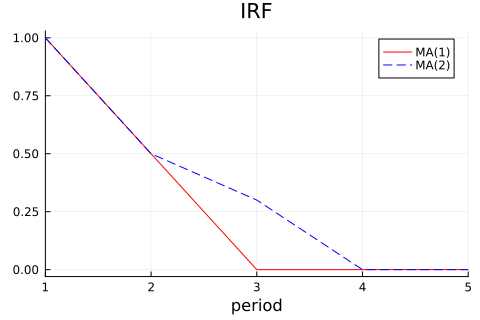

In [7]:
θ = 0.5              #MA(1)
(θ₁,θ₂) = (0.5,0.3)  #MA(2)

t_max  = 15

ϵ    = zeros(t_max)
ϵ[1] = 1                     #a single shock, otherwise zeros

y1 = ARMAFilter(ϵ,[],θ)
y2 = ARMAFilter(ϵ,[],[θ₁,θ₂])

p1 = plot( 1:t_max,[y1 y2],
           label = ["MA(1)" "MA(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xlims = (1,5),
           xlabel = "period",
           title = "IRF" )
display(p1)

## Estimation of an MA(q) (extra)

To estimate an MA model, we can apply MLE. For the numerical optimization we use the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package. 

The `MAqLL(par,y_data)` function (included above) calculates the likelihood function and returns it as its first output.

In [8]:
par0 = [0.5,0.3,0,0,1]   #θ₁,θ₂,θ₃,θ₄,σ         #estimate an MA(4)
LLtFun_MA(par,y,x) = MAqLL(par,y)[1]            #log likelihood fn
par, = MLE(LLtFun_MA,par0,y_data,nothing)

(θhat,σhat) = (par[1:end-1],par[end])

printblue("MLE of MA(4):\n")
printmat([θhat;σhat];colNames=["parameters"],rowNames=["θ₁","θ₂","θ₃","θ₄","σ"],width=15)

MLE of MA(4):

       parameters
θ₁          1.458
θ₂          1.552
θ₃          1.170
θ₄          0.516
σ           0.638



## Autocovariances

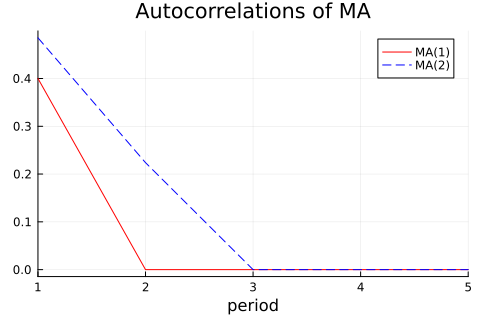

In [9]:
ρ1 =  MAqToAutocorr([θ],t_max)
ρ2 =  MAqToAutocorr([θ₁,θ₂],t_max)

p1 = plot( 1:t_max,[ρ1 ρ2],
           label = ["MA(1)" "MA(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xlims = (1,5),
           xlabel = "period",
           title = "Autocorrelations of MA" )
display(p1)

# Approximating an MA by an AR

by using the Yule-Walker equations

In [10]:
a2 = YuleWalker([1;ρ2[1:2]])
a3 = YuleWalker([1;ρ2[1:3]])

printblue("MA(2)")
printmat([θ₁,θ₂],rowNames=["θ₁","θ₂"])

printblue("Approximating MA(2) by AR(2)")
printmat(a2;rowNames=["a₁","a₂"])

printblue("Approximating MA(2) by AR(3)")
printmat(a3;rowNames=["a₁","a₂","a₃"])

MA(2)
θ₁     0.500
θ₂     0.300

Approximating MA(2) by AR(2)
a₁     0.492
a₂    -0.015

Approximating MA(2) by AR(3)
a₁     0.490
a₂     0.051
a₃    -0.135



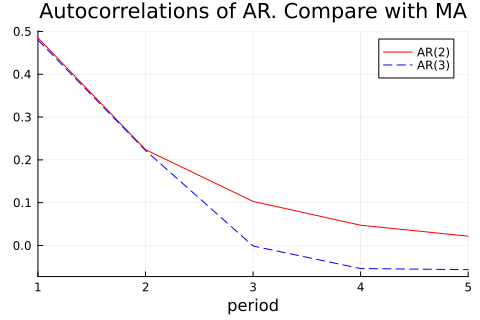

In [11]:
A_ar2, = CompanionFormAR(a2)               #AR(2) to companion form
(_,_,ρ_ar2) = VAR1AutoCov(A_ar2,t_max;m=1)     #implied autocorrelations

A_ar3, = CompanionFormAR(a3)               #AR(2) to companion form
(_,_,ρ_ar3) = VAR1AutoCov(A_ar3,t_max;m=1)     #implied autocorrelations

p1 = plot( 1:t_max,[ρ_ar2 ρ_ar3],
           label = ["AR(2)" "AR(3)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xlims = (1,5),
           xlabel = "period",
           title = "Autocorrelations of AR. Compare with MA" )
display(p1)